# Modèles utlisant des réseaux de neurones

In [108]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('train.csv')

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# On sélectionne les colonnes d'entrée (features) et la cible
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# On sélectionne les colonnes d'entrée (features) et la cible
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# On divise les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# On normalise les données continues 
from sklearn.preprocessing import StandardScaler

continuous_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
                      'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
                      'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
scaler = StandardScaler()

# On applique le scaler uniquement sur les colonnes continues
X_train[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test[continuous_columns] = scaler.transform(X_test[continuous_columns])

# On ajuste les labels pour qu'ils commencent à 0 pour XGBoost
y_train_adj = y_train - 1
y_test_adj = y_test - 1

Pour prédire le type de couverture forestière avec un réseau de neurones, on va utiliser une architecture de réseau de neurones MLP (Multi Layer Perceptron) (par opposition aux CNN, RNN ou LSTM/GRU), qui est efficace pour la classification de variables catégorielles

## Premier essai

In [197]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Définir le nombre de classes
num_classes = len(np.unique(y_train))

# Définition du modèle de réseau de neurones
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    
    Dense(512),
    LeakyReLU(negative_slope=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256),
    LeakyReLU(negative_slope=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128),
    LeakyReLU(negative_slope=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.005), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [204]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Entraînement du modèle
history = model.fit(X_train, y_train_adj, 
                    epochs=500, 
                    batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[early_stopping, reduce_lr],
                    verbose=0)

In [206]:
# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test_adj)
print(f"Test Accuracy: {test_accuracy:.2f}")

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.5024 - loss: 1.1807
Test Accuracy: 0.50


In [162]:
test_loss, test_accuracy = model.evaluate(X_train, y_train_adj)
print(f"Train Accuracy: {test_accuracy:.2f}")

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.5525 - loss: 1.0493
Train Accuracy: 0.55


## Optimisation des hyperparamètres

In [127]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# Définition de l'espace de recherche
space = {
    'units_layer_1': hp.choice('units_layer_1', [256, 512, 768, 1024]),
    'units_layer_2': hp.choice('units_layer_2', [128, 256, 512, 768]),
    'units_layer_3': hp.choice('units_layer_3', [64, 128, 256, 512]),
    'dropout_rate_1': hp.uniform('dropout_rate_1', 0.3, 0.5),
    'dropout_rate_2': hp.uniform('dropout_rate_2', 0.2, 0.5),
    'dropout_rate_3': hp.uniform('dropout_rate_3', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'negative_slope': hp.uniform('negative_slope', 0.1, 0.3)
}


In [131]:
def build_and_train_model(params):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],))) 

    model.add(Dense(units=params['units_layer_1']))
    model.add(LeakyReLU(negative_slope=params['negative_slope']))
    model.add(BatchNormalization())
    model.add(Dropout(rate=params['dropout_rate_1']))

    model.add(Dense(units=params['units_layer_2']))
    model.add(LeakyReLU(negative_slope=params['negative_slope']))
    model.add(BatchNormalization())
    model.add(Dropout(rate=params['dropout_rate_2']))

    model.add(Dense(units=params['units_layer_3']))
    model.add(LeakyReLU(negative_slope=params['negative_slope']))
    model.add(BatchNormalization())
    model.add(Dropout(rate=params['dropout_rate_3']))

    model.add(Dense(num_classes, activation='softmax'))

    # Compilation du modèle avec le learning rate initial fourni par Hyperopt
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Callbacks pour ajuster dynamiquement le learning rate
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-4)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Entraînement du modèle avec le scheduler
    history = model.fit(X_train, y_train_adj,
                        epochs=50,
                        batch_size=32,
                        validation_split=0.2,
                        callbacks=[reduce_lr, early_stopping],
                        verbose=0)

    # Calcul de la perte de validation pour Hyperopt
    val_accuracy = max(history.history['val_accuracy'])  # Utiliser la meilleure val_accuracy atteinte
    return {'loss': -val_accuracy, 'status': STATUS_OK}  # Hyperopt cherche à minimiser, d'où le signe "-"



In [132]:
trials = Trials()  # Permet de sauvegarder les résultats de chaque essai

best = fmin(
    fn=build_and_train_model,  # La fonction d'objectif
    space=space,               # L'espace de recherche
    algo=tpe.suggest,          # Algorithme d'optimisation
    max_evals=20,              # Nombre maximum d'essais (ajustez selon vos ressources)
    trials=trials              # Enregistrer les essais
)

print("Meilleurs hyperparamètres trouvés : ", best)


100%|██████████| 20/20 [09:13<00:00, 27.67s/trial, best loss: -0.4048181474208832]
Meilleurs hyperparamètres trouvés :  {'dropout_rate_1': 0.39699016854246727, 'dropout_rate_2': 0.20794955999830833, 'dropout_rate_3': 0.32672836861137483, 'learning_rate': 0.017552614907074188, 'negative_slope': 0.17239294218566548, 'units_layer_1': 0, 'units_layer_2': 0, 'units_layer_3': 3}


On veut maintenant tester ce modèle.

In [140]:
units_options_layer_1 = [256, 512, 768, 1024]
units_options_layer_2 = [128, 256, 512, 768]
units_options_layer_3 = [64, 128, 256, 512]

def build_final_model(best_params):
    # Récupération des valeurs réelles de neurones en fonction des indices optimaux trouvés
    units_layer_1 = units_options_layer_1[best_params['units_layer_1']]
    units_layer_2 = units_options_layer_2[best_params['units_layer_2']]
    units_layer_3 = units_options_layer_3[best_params['units_layer_3']]

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],))) 

    model.add(Dense(units=units_layer_1))
    model.add(LeakyReLU(negative_slope=best_params['negative_slope']))
    model.add(BatchNormalization())
    model.add(Dropout(rate=best_params['dropout_rate_1']))

    model.add(Dense(units=units_layer_2))
    model.add(LeakyReLU(negative_slope=best_params['negative_slope']))
    model.add(BatchNormalization())
    model.add(Dropout(rate=best_params['dropout_rate_2']))

    model.add(Dense(units=units_layer_3))
    model.add(LeakyReLU(negative_slope=best_params['negative_slope']))
    model.add(BatchNormalization())
    model.add(Dropout(rate=best_params['dropout_rate_3']))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Construire le modèle final avec les meilleurs hyperparamètres
final_model = build_final_model(best)

In [284]:
# Définir le callback pour réduire le learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-4)
early_stopping = EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)

# Entraîner le modèle final avec le callback ReduceLROnPlateau
history = final_model.fit(X_train, y_train_adj,
                          epochs=10000, 
                          batch_size=64, 
                          validation_split=0.2,
                          callbacks=[reduce_lr, early_stopping],
                          verbose=0)

In [285]:
test_loss, test_accuracy = final_model.evaluate(X_test, y_test_adj)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.7268 - loss: 0.6325
Test Loss: 0.640326738357544
Test Accuracy: 0.7259700298309326


Le résultat reste décevant.

## Autres solutions

In [176]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Préparer les données sous forme de tenseurs PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_adj.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_adj.values, dtype=torch.long)

# Créer des DataLoader pour l'entraînement et le test
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

In [255]:
# Définir le modèle MLP
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            
            nn.Linear(512, 512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Initialiser le modèle, la fonction de perte et l'optimiseur
input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = NeuralNet(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate réduit
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

# Fonction pour l'entraînement
def train(model, train_loader, criterion, optimizer, device='cpu'):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Réinitialiser les gradients
        optimizer.zero_grad()
        
        # Calculer les prédictions et la perte
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backpropagation et optimisation
        loss.backward()
        optimizer.step()
        
        # Ajouter la perte de ce batch au total
        running_loss += loss.item() * X_batch.size(0)
    
    # Calculer la perte moyenne pour cette epoch
    return running_loss / len(train_loader.dataset)

# Fonction pour l'évaluation
def evaluate(model, data_loader, criterion, device='cpu'):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():  # Désactiver le calcul des gradients pour l’évaluation
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Calculer les prédictions et la perte
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            
            # Calculer les prédictions correctes
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    # Calculer la perte moyenne et la précision
    accuracy = 100 * correct / total
    return val_loss / len(data_loader.dataset), accuracy


In [282]:
# Entraînement avec early stopping
num_epochs = 1000
early_stopping_patience = 200
best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses = [], []

# Boucle principale d'entraînement et d'évaluation
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy = evaluate(model, test_loader, criterion)
    scheduler.step(val_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

Epoch [50/1000], Train Loss: 0.7487, Val Loss: 0.7736, Val Accuracy: 66.84%
Epoch [100/1000], Train Loss: 0.7462, Val Loss: 0.6656, Val Accuracy: 71.16%
Epoch [150/1000], Train Loss: 0.7455, Val Loss: 0.6696, Val Accuracy: 70.75%
Epoch [200/1000], Train Loss: 0.7663, Val Loss: 0.6605, Val Accuracy: 71.76%
Epoch [250/1000], Train Loss: 0.7619, Val Loss: 0.7569, Val Accuracy: 67.84%
Epoch [300/1000], Train Loss: 0.7498, Val Loss: 0.7115, Val Accuracy: 69.49%
Epoch [350/1000], Train Loss: 0.7356, Val Loss: 0.7108, Val Accuracy: 67.22%
Epoch [400/1000], Train Loss: 0.7498, Val Loss: 0.6679, Val Accuracy: 70.33%
Epoch [450/1000], Train Loss: 0.7343, Val Loss: 0.7277, Val Accuracy: 67.24%
Epoch [500/1000], Train Loss: 0.7389, Val Loss: 0.6634, Val Accuracy: 71.03%
Epoch [550/1000], Train Loss: 0.7421, Val Loss: 0.6613, Val Accuracy: 71.01%
Epoch [600/1000], Train Loss: 0.7426, Val Loss: 0.6878, Val Accuracy: 70.46%
Epoch [650/1000], Train Loss: 0.7342, Val Loss: 0.6998, Val Accuracy: 70.00%


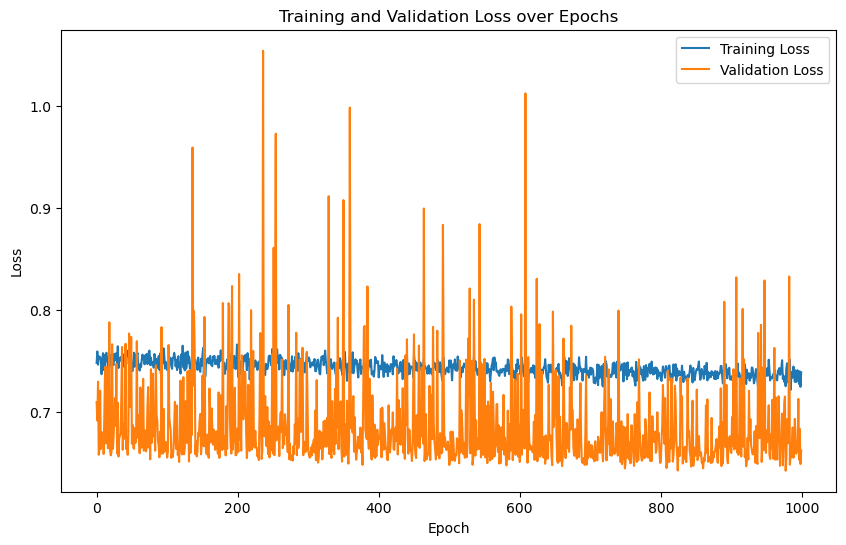

Test Loss: 0.6626, Test Accuracy: 71.30%


In [286]:
# Tracer la courbe de la perte pour vérifier la convergence
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Évaluation finale sur l'ensemble de test
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')